### CIQ Scraper Workbook

##### 1. Statement

This workbook is an illustration on extracting, formulating, and exporting companies' data from S&P CIQ database. The following codes are only for internal use of ABB's consulting practicum project and research purpose. For more details of the data source, please refer to https://www.spglobal.com/marketintelligence/en/index.

##### 2. Code

In [7]:
def show_screen():
    bot.save_screenshot("out.png")
    display(Image("out.png"))

##### 2.1 *page_login(username, password, url)*

In this project, we use selenium to create a webdriver bot to visit the CIQ website, the following code snippet includes all the necessary and optional Python libraries that would be used in this script.

In [2]:
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from bs4 import BeautifulSoup
import pandas as pd
import lxml
import getpass
from IPython.display import display, Image
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import time

In [3]:
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--disable-dve-shm-uage')

The page_login() function allows users to create a selenium webdriver object to automatically visit the CIQ database. Users need to input their own usernames and passwords and the url of the login page to get access to the database.

In [4]:
def page_login(username, password, url):
    bot = webdriver.Chrome(options=options)
    wait = WebDriverWait(bot, 20)
    bot.get(url)
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, "#onetrust-accept-btn-handler"))).click()

    time.sleep(2)

    bot.find_element(By.ID, 'input28').send_keys(username)
    bot.find_element(By.ID, 'input28').send_keys(Keys.RETURN)

    time.sleep(2)

    password_field = bot.find_element(By.ID, 'input60')
    password_field.send_keys(password)
    password_field.send_keys(Keys.RETURN)

    time.sleep(2)

    return bot   

Users would be required to enter their CIQ account and password to get access to the database. The url of the login page is also provided in the following code snippet.

In [5]:
username = 'bxie43@wisc.edu'
password = 'Ben803803`'
login_url = 'https://www.capitaliq.com/CIQDotNet/login-okta.aspx'

Example: Create a Bot

In [6]:
bot = page_login(username, password, login_url)

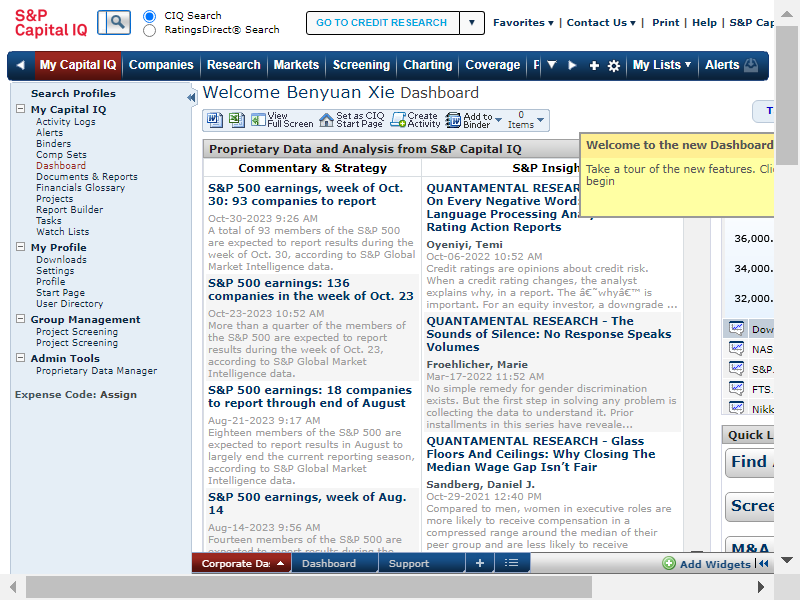

In [8]:
show_screen()

##### 2.2 *get_company_data(bot, company_id, url, tag, idx)*

From the CIQ database, we extract six variables for each company in the F&B Manufacturing industry. These variables include customers, competitors, alliances, sourcing of raw materials, acquisitions and key brands.


For the get_company_data() function, the necessary arguments include `bot` that specifies the bot created by the users, `company_id` that identifies different companies (these ids are defined by Capital IQ and would be provided in the `company_id_spciq` column of `master_excel_all_variables.xlsx`), `url` that specifies the variables users are searching for, `tag` that specifies the element the bot should extract from the webpage, and `idx` that specifies the meta data for each table. Searching for the data for a new company that is not in the csv file would require users to update the `company_id` in a new record.

In [11]:
def get_company_data(bot, company_id, url, tag, idx):
    
    bot.get(url.format(company_id))

    df = None 
    
    try:
        table = bot.find_element(By.ID, tag)

        data = []
        for row in table.find_elements(By.TAG_NAME, "tr"):
            row_data = [cell.text for cell in row.find_elements(By.TAG_NAME, "td")]
            if row_data:
                data.append(row_data)
        headers = data[0]
        non_empty_headers = [header.strip() for header in headers if header]
        cleaned_rows = [[cell for cell in row if cell] for row in data[1:]]
        cleaned_rows = [row for row in cleaned_rows if any(cell for cell in row if cell)]

        if len(cleaned_rows) > 0: # Check if it has multiple rows
            try:
                df = pd.DataFrame(cleaned_rows[1:], columns=non_empty_headers) 
            except ValueError:
                try:
                    df = pd.DataFrame([cleaned_rows[0]], columns=non_empty_headers)  # Ensure this is a list of lists
                except Exception:
                    pass
        else: # Text extraction
            df = pd.DataFrame([table.text.replace('\n\n', ';')], columns = idx)
            
    except NoSuchElementException: # Data not disclosured
        df = pd.DataFrame([" "] * len(idx), index=idx).T
    
    # Only proceed if df is successfully created
    if df is not None:
        df.insert(0, 'company_id', str(company_id))
        if len(df[:-1]) != 0:
            df = df[:-1]

    return df

Example: Getting ADM's customer data

In [12]:
customers_url = 'https://www.capitaliq.com/CIQDotNet/BusinessRel/Customers.aspx?CompanyId={}'
customers_index = ['Customer Name', 'Supplier Name', 'Relationship Type', 'Primary Industry', 'Source']
customers_tag = 'myCustomersGrid_gridSection_myDataGrid'
company_id = 251704 # Assumue using the id of ADM
get_company_data(bot, company_id, customers_url, customers_tag, customers_index)

,company_id,Customer Name,Supplier Name,Relationship Type,Primary Industry,Source
0,251704,"Coca-Cola FEMSA, S.A.B. de C.V. (NYSE:KOF)","Almidones Mexicanos, S.A. de C.V.",Customer,Soft Drinks and Non-alcoholic Beverages,"Coca-Cola FEMSA, S.A.B. de C.V. (NYSE:KOF) 202..."
1,251704,Edible Oils Ltd.,Archer-Daniels-Midland Company (NYSE:ADM),Customer,Packaged Foods and Meats,Archer-Daniels-Midland Company (NYSE:ADM) 2023...
2,251704,"Formosa Oilseed Processing Co., Ltd. (TWSE:1225)",Archer-Daniels-Midland Company (NYSE:ADM),Customer,Packaged Foods and Meats,"Formosa Oilseed Processing Co., Ltd. (TWSE:122..."
3,251704,"Glucose Health, Inc. (OTCPK:GLUC)",Archer-Daniels-Midland Company (NYSE:ADM),Customer,Personal Care Products,"Glucose Health, Inc. (OTCPK:GLUC) 2022 Form S-1"
4,251704,OLENEX C.V.,Archer-Daniels-Midland Company (NYSE:ADM),Customer,Food Distributors,Archer-Daniels-Midland Company (NYSE:ADM) 2018...
5,251704,Olenex Sàrl,Archer-Daniels-Midland Company (NYSE:ADM),Customer,Packaged Foods and Meats,Archer-Daniels-Midland Company (NYSE:ADM) 2023...
6,251704,SoyVen,Archer-Daniels-Midland Company (NYSE:ADM),Customer,Archer-Daniels-Midland Company (NYSE:ADM) 2023...,None
7,251704,"Stratas Foods, LLC",Archer-Daniels-Midland Company (NYSE:ADM),Customer,Packaged Foods and Meats,Archer-Daniels-Midland Company (NYSE:ADM) 2023...
8,251704,Thaifoods Group Public Company Limited (SET:TFG),ADM Asia-Pacific Trading Pte. Ltd.,Customer,Packaged Foods and Meats,Thaifoods Group Public Company Limited (SET:TF...
9,251704,Wilmar International Limited (SGX:F34),Archer-Daniels-Midland Company (NYSE:ADM),Customer,Agricultural Products and Services,Archer-Daniels-Midland Company (NYSE:ADM) 2023...


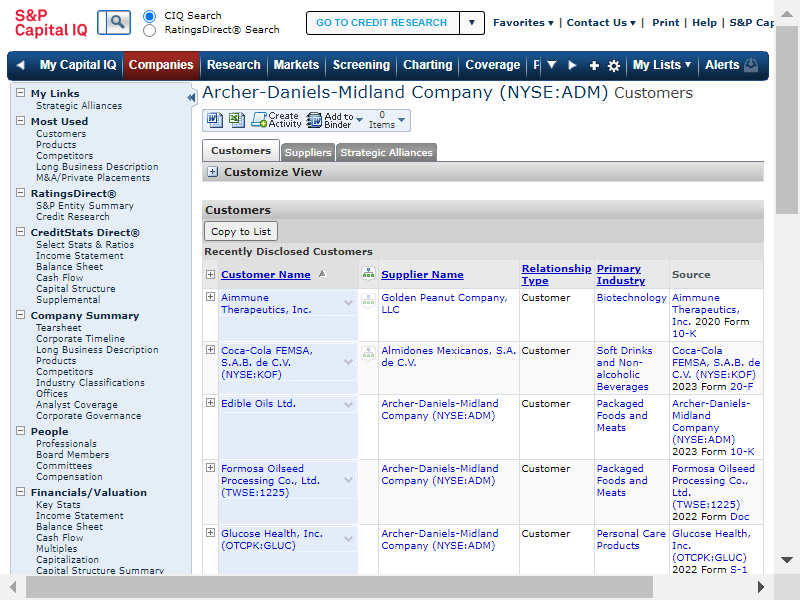

In [13]:
show_screen()

##### 2.3 *merge_tables(tb1, tb2)*

The merge_tables(tb1, tb2) function allows users to merge the dataframes of different companies.

In [7]:
def merge_tables(tb1, tb2):
    return pd.concat([tb1, tb2], axis = 0)

In [4]:
master_idx = pd.read_excel("master_excel_all_variables.xlsx", sheet_name='master_excel_all_variables')
company_list = master_idx['company_id_spciq']

Example: Merging all the customer data for all the companies in the master sheet.

In [12]:
customers_table = pd.DataFrame()
for company_id in company_list:
    customers_table = merge_tables(customers_table, get_company_data(bot, company_id, customers_url, customers_tag, customers_index))

In [13]:
customers_table

,company_id,Customer Name,Supplier Name,Relationship Type,Primary Industry,Source
0,251704,"Coca-Cola FEMSA, S.A.B. de C.V. (NYSE:KOF)","Almidones Mexicanos, S.A. de C.V.",Customer,Soft Drinks and Non-alcoholic Beverages,"Coca-Cola FEMSA, S.A.B. de C.V. (NYSE:KOF) 202..."
1,251704,Edible Oils Ltd.,Archer-Daniels-Midland Company (NYSE:ADM),Customer,Packaged Foods and Meats,Archer-Daniels-Midland Company (NYSE:ADM) 2023...
2,251704,"Formosa Oilseed Processing Co., Ltd. (TWSE:1225)",Archer-Daniels-Midland Company (NYSE:ADM),Customer,Packaged Foods and Meats,"Formosa Oilseed Processing Co., Ltd. (TWSE:122..."
3,251704,"Glucose Health, Inc. (OTCPK:GLUC)",Archer-Daniels-Midland Company (NYSE:ADM),Customer,Personal Care Products,"Glucose Health, Inc. (OTCPK:GLUC) 2022 Form S-1"
4,251704,OLENEX C.V.,Archer-Daniels-Midland Company (NYSE:ADM),Customer,Food Distributors,Archer-Daniels-Midland Company (NYSE:ADM) 2018...
...,...,...,...,...,...,...
0,303591,Fresh Del Monte Produce Inc. (NYSE:FDP),"Big Heart Pet Brands, Inc.",Licensee,Agricultural Products and Services,Fresh Del Monte Produce Inc. (NYSE:FDP) 2023 F...
1,303591,"Nongshim Co., Ltd. (KOSE:A004370)",The Folger Coffee Company Inc.,Distributor,Packaged Foods and Meats,"Nongshim Co., Ltd. (KOSE:A004370) - Form Doc"
2,303591,"Nongshim Co., Ltd. (KOSE:A004370)",The J. M. Smucker Company (NYSE:SJM),Distributor,Packaged Foods and Meats,"Nongshim Co., Ltd. (KOSE:A004370) - Form Doc"
3,303591,Walmart Inc. (NYSE:WMT),"Hostess Brands, Inc.",Distributor,Consumer Staples Merchandise Retail,"Hostess Brands, Inc. 2023 Form 10-K"


In [14]:
customers_table.to_csv('customers.csv', index=False)